Expected Inside 50 Model

In [1]:
import sys
sys.path.append("/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-i50-model/")

In [7]:
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')

from expected_i50_model.config import modelling_file_path
from expected_i50_model.src.modelling_data_contract import ModellingDataContract
from expected_i50_model.src.modelling.model_evaluation import XGBClassifierEvaluator

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


New Model

In [3]:
new_version = 1
model_name = "expected_i50"
model_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-i50-model/model_outputs/models"
preproc_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-i50-model/model_outputs/preprocessors"

Comparison Model

In [4]:
# old_version = new_version - 1
# compare_train_predictions_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/predictions/train_predictions_"+model_name+"_v"+str(old_version)+".csv"
# compare_test_predictions_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/predictions/test_predictions_"+model_name+"_v"+str(old_version)+".csv"

Response

In [5]:
RESPONSE = ModellingDataContract.RESPONSE

Features

In [6]:
FEATURES = ModellingDataContract.feature_list

Load Data

In [8]:
df_modelling = pd.read_csv(modelling_file_path)
df_modelling.tail()

,match_id,chain_number,order,quarter,quarter_seconds,overall_seconds,team,player,start_x,start_y,end_x,end_y,action_type,outcome_type,quarter_a0,quarter_seconds_a0,overall_seconds_a0,start_x_a0,start_y_a0,end_x_a0,end_y_a0,dx_a0,dy_a0,movement_a0,outcome_effective_a1,outcome_ineffective_a1,outcome_clanger_a1,quarter_a1,quarter_seconds_a1,overall_seconds_a1,start_x_a1,start_y_a1,end_x_a1,end_y_a1,dx_a1,dy_a1,movement_a1,outcome_effective_a2,outcome_ineffective_a2,outcome_clanger_a2,quarter_a2,quarter_seconds_a2,overall_seconds_a2,start_x_a2,start_y_a2,end_x_a2,end_y_a2,dx_a2,dy_a2,movement_a2,team_1,team_2,time_delta1,time_delta2,dx_a01,dy_a01,move_a01,dx_a02,dy_a02,move_a02,Inside50,Inside50TrainingSet,Inside50TestSet,Inside50ValidationSet
54732,2023F4_Collingwood_BrisbaneLions,226,1752.0,4,1461.0,7449.0,Collingwood,Josh Daicos,14.0,-16.0,-48.0,16.0,Kick Inside 50,clanger,4,1461.0,7449.0,14.0,-16.0,-48.0,16.0,-62.0,32.0,69.771054,True,False,False,4,1461.0,7449.0,14.0,-16.0,14.0,-16.0,0.0,0.0,0.000000,True,False,False,4,1460.0,7448.0,13.0,-11.0,14.0,-16.0,1.0,-5.0,5.099020,True,True,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,True,False
54733,2023F4_Collingwood_BrisbaneLions,229,1771.0,4,1491.0,7479.0,Collingwood,Steele Sidebottom,11.0,15.0,71.0,21.0,Kick Inside 50,effective,4,1491.0,7479.0,11.0,15.0,71.0,21.0,60.0,6.0,60.299254,True,False,False,4,1490.0,7478.0,10.0,15.0,11.0,15.0,1.0,0.0,1.000000,False,False,True,4,1489.0,7477.0,-24.0,-0.0,11.0,15.0,35.0,15.0,38.078866,True,False,-1.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,1,True,False,False
54734,2023F4_Collingwood_BrisbaneLions,231,1784.0,4,1554.0,7542.0,Collingwood,Steele Sidebottom,25.0,63.0,-69.0,-31.0,Kick Inside 50,effective,4,1554.0,7542.0,25.0,63.0,-69.0,-31.0,-94.0,-94.0,132.936075,True,False,False,4,1543.0,7531.0,30.0,60.0,25.0,63.0,-5.0,3.0,5.830952,True,False,False,4,1542.0,7530.0,15.0,42.0,25.0,63.0,10.0,21.0,23.259407,True,True,-11.0,-12.0,0.0,0.0,0.0,0.0,0.0,0.0,1,True,False,False
54735,2023F4_Collingwood_BrisbaneLions,233,1799.0,4,1610.0,7598.0,Brisbane Lions,Lachie Neale,-10.0,-9.0,-45.0,-0.0,Kick Inside 50,effective,4,1610.0,7598.0,-10.0,-9.0,-45.0,-0.0,-35.0,9.0,36.138622,True,False,False,4,1605.0,7593.0,-8.0,-17.0,-10.0,-9.0,-2.0,8.0,8.246211,False,True,False,4,1595.0,7583.0,-20.0,-14.0,-10.0,-9.0,10.0,5.0,11.180340,True,True,-5.0,-15.0,0.0,0.0,0.0,0.0,0.0,0.0,1,False,True,False
54736,2023F4_Collingwood_BrisbaneLions,236,1822.0,4,1707.0,7695.0,Brisbane Lions,Zac Bailey,29.0,31.0,-47.0,-10.0,Kick Inside 50,ineffective,4,1707.0,7695.0,29.0,31.0,-47.0,-10.0,-76.0,-41.0,86.353923,True,False,False,4,1706.0,7694.0,32.0,28.0,29.0,31.0,-3.0,3.0,4.242641,True,False,False,4,1705.0,7693.0,28.0,21.0,29.0,31.0,1.0,10.0,10.049876,True,True,-1.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,False,True


In [9]:
training_data = df_modelling[df_modelling[RESPONSE+"TrainingSet"]]
test_data = df_modelling[df_modelling[RESPONSE+"TestSet"]]
cal_data = df_modelling[df_modelling[RESPONSE+"ValidationSet"]]

In [10]:
X_train, y_train = training_data.drop(columns=[RESPONSE]), training_data[RESPONSE]
X_test, y_test = test_data.drop(columns=[RESPONSE]), test_data[RESPONSE]
X_cal, y_cal = cal_data.drop(columns=[RESPONSE]), cal_data[RESPONSE]

In [11]:
X_test.head()

,match_id,chain_number,order,quarter,quarter_seconds,overall_seconds,team,player,start_x,start_y,end_x,end_y,action_type,outcome_type,quarter_a0,quarter_seconds_a0,overall_seconds_a0,start_x_a0,start_y_a0,end_x_a0,end_y_a0,dx_a0,dy_a0,movement_a0,outcome_effective_a1,outcome_ineffective_a1,outcome_clanger_a1,quarter_a1,quarter_seconds_a1,overall_seconds_a1,start_x_a1,start_y_a1,end_x_a1,end_y_a1,dx_a1,dy_a1,movement_a1,outcome_effective_a2,outcome_ineffective_a2,outcome_clanger_a2,quarter_a2,quarter_seconds_a2,overall_seconds_a2,start_x_a2,start_y_a2,end_x_a2,end_y_a2,dx_a2,dy_a2,movement_a2,team_1,team_2,time_delta1,time_delta2,dx_a01,dy_a01,move_a01,dx_a02,dy_a02,move_a02,Inside50TrainingSet,Inside50TestSet,Inside50ValidationSet
1,202101_BrisbaneLions_Sydney,2,23.0,1,108.0,108.0,Brisbane Lions,Zac Bailey,37.0,56.0,46.0,22.0,Kick Inside 50,ineffective,1,108.0,108.0,37.0,56.0,46.0,22.0,9.0,-34.0,35.171011,True,False,False,1,108.0,108.0,34.0,55.0,37.0,56.0,3.0,1.0,3.162278,False,True,False,1,104.0,104.0,34.0,41.0,37.0,56.0,3.0,15.0,15.297059,True,True,0.0,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True,False
2,202101_BrisbaneLions_Sydney,7,72.0,1,234.0,234.0,Brisbane Lions,Mitch Robinson,29.0,-23.0,60.0,-31.0,Kick Inside 50,ineffective,1,234.0,234.0,29.0,-23.0,60.0,-31.0,31.0,-8.0,32.015621,True,False,False,1,232.0,232.0,26.0,-23.0,29.0,-23.0,3.0,0.0,3.000000,True,False,False,1,231.0,231.0,26.0,-10.0,29.0,-23.0,3.0,-13.0,13.341664,True,True,-2.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True,False
13,202101_BrisbaneLions_Sydney,29,305.0,1,964.0,964.0,Brisbane Lions,Daniel Rich,45.0,-51.0,50.0,-5.0,Kick Inside 50,ineffective,1,964.0,964.0,45.0,-51.0,50.0,-5.0,5.0,46.0,46.270941,True,False,False,1,960.0,960.0,36.0,-54.0,45.0,-51.0,9.0,3.0,9.486833,True,False,False,1,959.0,959.0,21.0,-46.0,45.0,-51.0,24.0,-5.0,24.515301,True,True,-4.0,-5.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True,False
23,202101_BrisbaneLions_Sydney,55,543.0,1,1670.0,1670.0,Sydney,Dane Rampe,13.0,60.0,54.0,26.0,Kick Inside 50,clanger,1,1670.0,1670.0,13.0,60.0,54.0,26.0,41.0,-34.0,53.263496,True,False,False,1,1665.0,1665.0,24.0,58.0,13.0,60.0,-11.0,2.0,11.180340,True,False,False,1,1659.0,1659.0,-72.0,-16.0,13.0,60.0,85.0,76.0,114.021928,True,False,-5.0,-11.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True,False
49,202101_BrisbaneLions_Sydney,124,1095.0,3,222.0,4035.0,Brisbane Lions,Dayne Zorko,7.0,11.0,56.0,4.0,Kick Inside 50,effective,3,222.0,4035.0,7.0,11.0,56.0,4.0,49.0,-7.0,49.497475,True,False,False,3,216.0,4029.0,15.0,9.0,7.0,11.0,-8.0,2.0,8.246211,True,False,False,3,210.0,4023.0,-13.0,-8.0,7.0,11.0,20.0,19.0,27.586228,True,False,-6.0,-12.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True,False


In [13]:
X_train_preproc = X_train[FEATURES]
X_test_preproc = X_test[FEATURES]

In [14]:
X_train_preproc.shape, X_test_preproc.shape

((35031, 46), (10948, 46))

In [15]:
X_train_preproc.head()

,quarter_a0,quarter_seconds_a0,overall_seconds_a0,start_x_a0,start_y_a0,end_x_a0,end_y_a0,dx_a0,dy_a0,movement_a0,outcome_effective_a1,outcome_ineffective_a1,outcome_clanger_a1,quarter_a1,quarter_seconds_a1,overall_seconds_a1,start_x_a1,start_y_a1,end_x_a1,end_y_a1,dx_a1,dy_a1,movement_a1,outcome_effective_a2,outcome_ineffective_a2,outcome_clanger_a2,quarter_a2,quarter_seconds_a2,overall_seconds_a2,start_x_a2,start_y_a2,end_x_a2,end_y_a2,dx_a2,dy_a2,movement_a2,team_1,team_2,time_delta1,time_delta2,dx_a01,dy_a01,move_a01,dx_a02,dy_a02,move_a02
4,1,303.0,303.0,-8.0,44.0,50.0,28.0,58.0,-16.0,60.166436,True,False,False,1,299.0,299.0,-13.0,43.0,-8.0,44.0,5.0,1.0,5.099020,True,False,False,1,297.0,297.0,-18.0,52.0,-8.0,44.0,10.0,-8.0,12.806248,True,True,-4.0,-6.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,414.0,414.0,29.0,-34.0,70.0,-13.0,41.0,21.0,46.065171,True,False,False,1,407.0,407.0,35.0,-30.0,29.0,-34.0,-6.0,-4.0,7.211103,True,False,False,1,406.0,406.0,13.0,-59.0,29.0,-34.0,16.0,25.0,29.681644,True,True,-7.0,-8.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1,548.0,548.0,19.0,-49.0,49.0,-35.0,30.0,14.0,33.105891,True,False,False,1,544.0,544.0,13.0,-50.0,19.0,-49.0,6.0,1.0,6.082763,True,False,False,1,542.0,542.0,21.0,-57.0,19.0,-49.0,-2.0,8.0,8.246211,True,True,-4.0,-6.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1,625.0,625.0,29.0,58.0,62.0,18.0,33.0,-40.0,51.855569,True,False,False,1,620.0,620.0,22.0,57.0,29.0,58.0,7.0,1.0,7.071068,True,False,False,1,620.0,620.0,13.0,56.0,29.0,58.0,16.0,2.0,16.124515,True,True,-5.0,-5.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1,651.0,651.0,5.0,-66.0,43.0,-32.0,38.0,34.0,50.990195,True,False,False,1,651.0,651.0,1.0,-66.0,5.0,-66.0,4.0,0.0,4.000000,True,False,False,1,645.0,645.0,4.0,45.0,5.0,-66.0,1.0,-111.0,111.004504,True,False,0.0,-6.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
X_test_preproc.head()

,quarter_a0,quarter_seconds_a0,overall_seconds_a0,start_x_a0,start_y_a0,end_x_a0,end_y_a0,dx_a0,dy_a0,movement_a0,outcome_effective_a1,outcome_ineffective_a1,outcome_clanger_a1,quarter_a1,quarter_seconds_a1,overall_seconds_a1,start_x_a1,start_y_a1,end_x_a1,end_y_a1,dx_a1,dy_a1,movement_a1,outcome_effective_a2,outcome_ineffective_a2,outcome_clanger_a2,quarter_a2,quarter_seconds_a2,overall_seconds_a2,start_x_a2,start_y_a2,end_x_a2,end_y_a2,dx_a2,dy_a2,movement_a2,team_1,team_2,time_delta1,time_delta2,dx_a01,dy_a01,move_a01,dx_a02,dy_a02,move_a02
1,1,108.0,108.0,37.0,56.0,46.0,22.0,9.0,-34.0,35.171011,True,False,False,1,108.0,108.0,34.0,55.0,37.0,56.0,3.0,1.0,3.162278,False,True,False,1,104.0,104.0,34.0,41.0,37.0,56.0,3.0,15.0,15.297059,True,True,0.0,-4.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,234.0,234.0,29.0,-23.0,60.0,-31.0,31.0,-8.0,32.015621,True,False,False,1,232.0,232.0,26.0,-23.0,29.0,-23.0,3.0,0.0,3.000000,True,False,False,1,231.0,231.0,26.0,-10.0,29.0,-23.0,3.0,-13.0,13.341664,True,True,-2.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0
13,1,964.0,964.0,45.0,-51.0,50.0,-5.0,5.0,46.0,46.270941,True,False,False,1,960.0,960.0,36.0,-54.0,45.0,-51.0,9.0,3.0,9.486833,True,False,False,1,959.0,959.0,21.0,-46.0,45.0,-51.0,24.0,-5.0,24.515301,True,True,-4.0,-5.0,0.0,0.0,0.0,0.0,0.0,0.0
23,1,1670.0,1670.0,13.0,60.0,54.0,26.0,41.0,-34.0,53.263496,True,False,False,1,1665.0,1665.0,24.0,58.0,13.0,60.0,-11.0,2.0,11.180340,True,False,False,1,1659.0,1659.0,-72.0,-16.0,13.0,60.0,85.0,76.0,114.021928,True,False,-5.0,-11.0,0.0,0.0,0.0,0.0,0.0,0.0
49,3,222.0,4035.0,7.0,11.0,56.0,4.0,49.0,-7.0,49.497475,True,False,False,3,216.0,4029.0,15.0,9.0,7.0,11.0,-8.0,2.0,8.246211,True,False,False,3,210.0,4023.0,-13.0,-8.0,7.0,11.0,20.0,19.0,27.586228,True,False,-6.0,-12.0,0.0,0.0,0.0,0.0,0.0,0.0


Load Model

In [17]:
super_xgb = joblib.load(model_file_path + "/" + model_name + "_v" + str(new_version) + ".joblib")

In [18]:
super_xgb.xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.812493033979598, device=None,
              early_stopping_rounds=50, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.10557260377505404,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5505481233023182,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=60, missing=nan, monotone_constraints={},
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Get Predictions

In [19]:
train_preds = super_xgb.predict(X_train_preproc)
test_preds = super_xgb.predict(X_test_preproc)

In [20]:
train_probas = super_xgb.predict_proba(X_train_preproc)[:, 1]
test_probas = super_xgb.predict_proba(X_test_preproc)[:, 1]

In [21]:
train_cal_probas = super_xgb.predict_proba(X_train_preproc, calibrate=True)
test_cal_probas = super_xgb.predict_proba(X_test_preproc, calibrate=True)

Compare Model

In [22]:
# compare_train_data = pd.read_csv(compare_train_predictions_file_path)
# compare_test_data = pd.read_csv(compare_test_predictions_file_path)

In [23]:
# compare_train_data = compare_train_data.rename(columns = {'xgb_preds':'old_preds',
#                                                           'xgb_probas':'old_probas',
#                                                           'xgb_probas_cal':'old_cal_probas'})
# compare_test_data = compare_test_data.rename(columns = {'xgb_preds':'old_preds',
#                                                         'xgb_probas':'old_probas',
#                                                         'xgb_probas_cal':'old_cal_probas'})

In [24]:
training_data.shape

(35031, 64)

In [25]:
# training_data = pd.merge(training_data, compare_train_data[["Match_ID", "Chain_Number", "Order", 'old_preds', 'old_probas', 'old_cal_probas']], how = "left", on = ["Match_ID", "Chain_Number", "Order"])
# test_data = pd.merge(test_data, compare_test_data[["Match_ID", "Chain_Number", 'Order', 'old_preds', 'old_probas', 'old_cal_probas']], how = "left", on = ["Match_ID", "Chain_Number", "Order"])

Evaluate Model

In [26]:
training_data['xgb_preds'] = train_preds
training_data['xgb_probas'] = train_probas
training_data['xgb_cal_probas'] = train_cal_probas

train_xgb_evals = XGBClassifierEvaluator(model = super_xgb.xgb_model,
                                       data = training_data,
                                       actual_name = RESPONSE,
                                       expected_name = "xgb_cal_probas",
                                       expected_label_name = "xgb_preds"
                                       )

In [27]:
test_data['xgb_preds'] = test_preds
test_data['xgb_probas'] = test_probas
test_data['xgb_cal_probas'] = test_cal_probas

test_xgb_evals = XGBClassifierEvaluator(model = super_xgb.xgb_model,
                                       data = test_data,
                                       actual_name = RESPONSE,
                                       expected_name = "xgb_cal_probas",
                                       expected_label_name = "xgb_preds"
                                       )

Model Averages

In [28]:
training_data[[RESPONSE, 'xgb_probas', 'xgb_cal_probas']].describe()

,Inside50,xgb_probas,xgb_cal_probas
count,35031.000000,35031.000000,35031.000000
mean,0.671691,0.670936,0.668360
std,0.469605,0.208711,0.196187
min,0.000000,0.018015,0.015832
25%,0.000000,0.537691,0.551177
50%,1.000000,0.701935,0.699432
75%,1.000000,0.845830,0.827631
max,1.000000,0.991081,0.981773


In [29]:
test_data[[RESPONSE, 'xgb_probas', 'xgb_cal_probas']].describe()

,Inside50,xgb_probas,xgb_cal_probas
count,10948.000000,10948.000000,10948.000000
mean,0.669072,0.669788,0.667393
std,0.470569,0.207514,0.194955
min,0.000000,0.027576,0.025261
25%,0.000000,0.535052,0.548726
50%,1.000000,0.696530,0.694647
75%,1.000000,0.845414,0.827250
max,1.000000,0.984828,0.972385


Plots

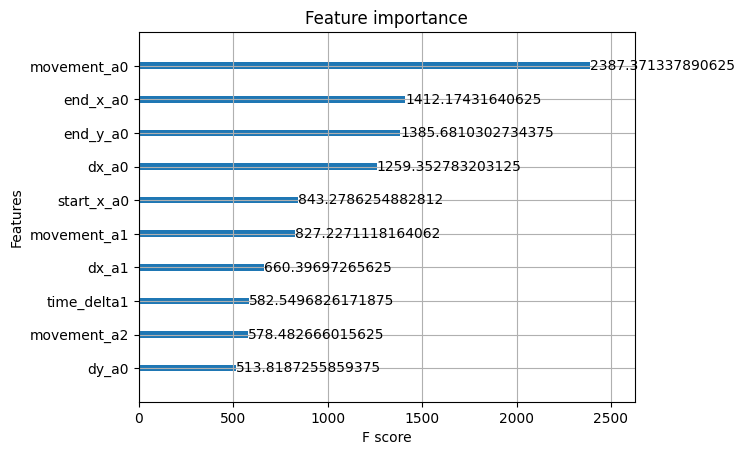

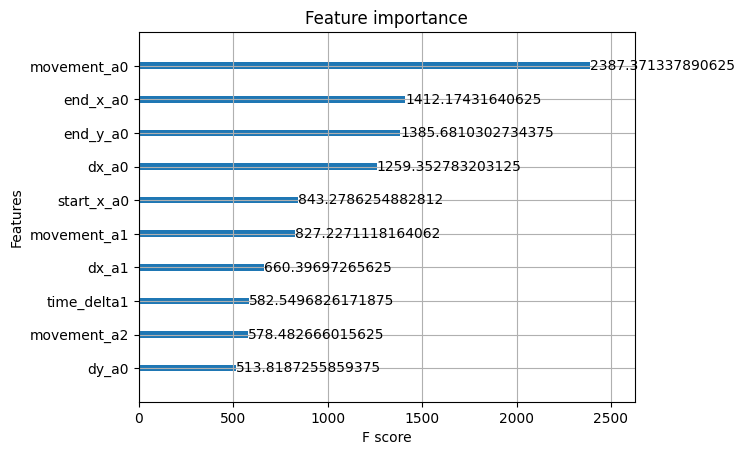

In [30]:
train_xgb_evals.plot_feature_importance(max_num_features=10, importance_type="total_gain")
test_xgb_evals.plot_feature_importance(max_num_features=10, importance_type="total_gain")

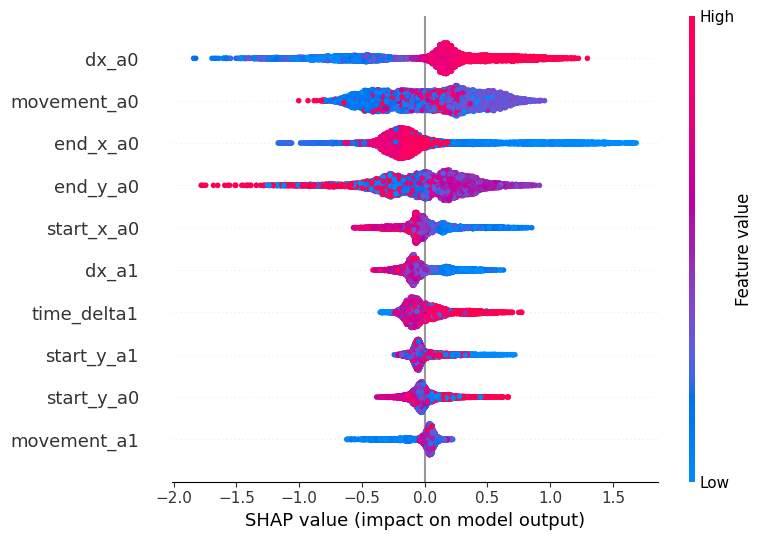

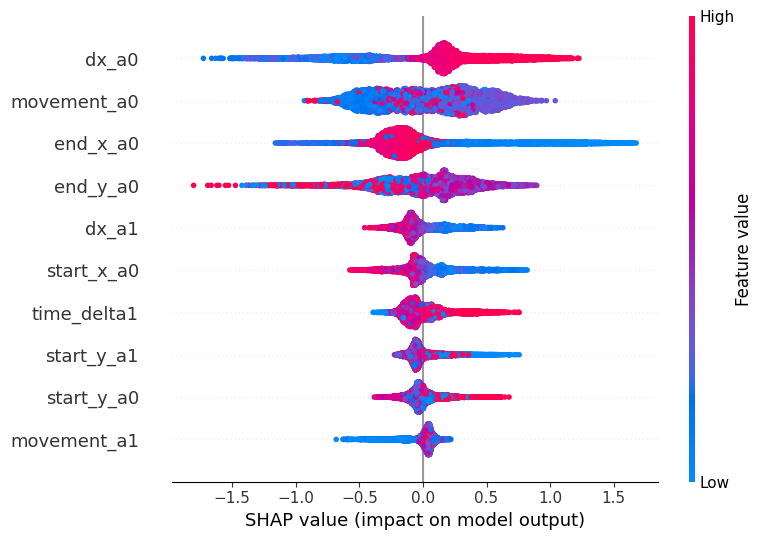

In [31]:
train_xgb_evals.plot_shap_summary_plot()
test_xgb_evals.plot_shap_summary_plot()

In [32]:
top_features = test_xgb_evals.get_ranked_feature_importance()
top_10_features = top_features[:10]
top_10_features

['dx_a0',
 'movement_a0',
 'end_x_a0',
 'end_y_a0',
 'dx_a1',
 'start_x_a0',
 'time_delta1',
 'start_y_a1',
 'start_y_a0',
 'movement_a1']

In [34]:
# for col in top_10_features:
#     train_xgb_evals.plot_pdp([col])
#     test_xgb_evals.plot_pdp([col])

In [35]:
# for col in top_10_features:
#     train_xgb_evals.plot_ice([col])
#     test_xgb_evals.plot_ice([col])

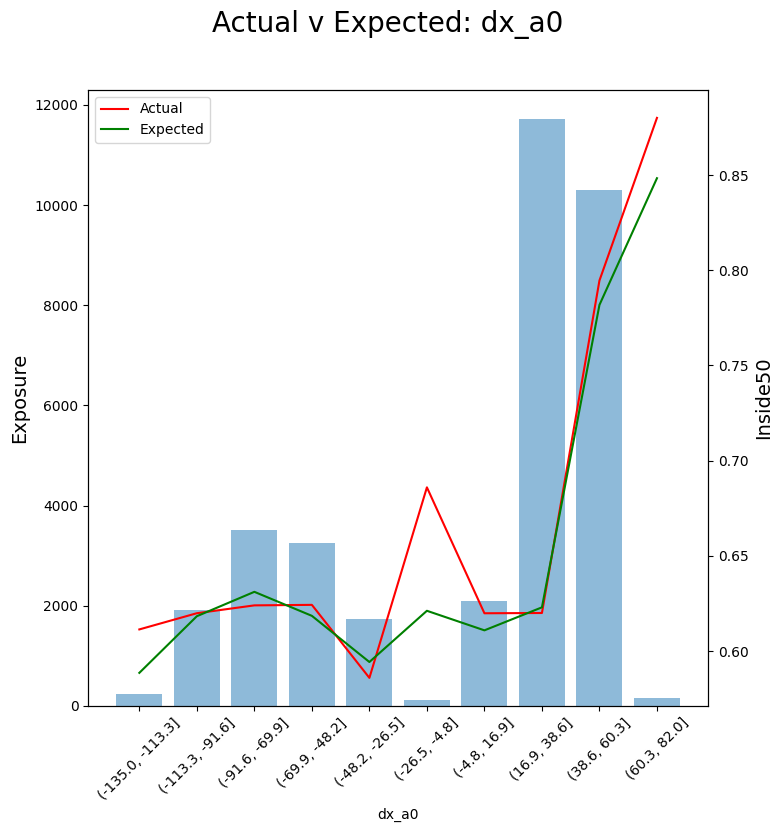

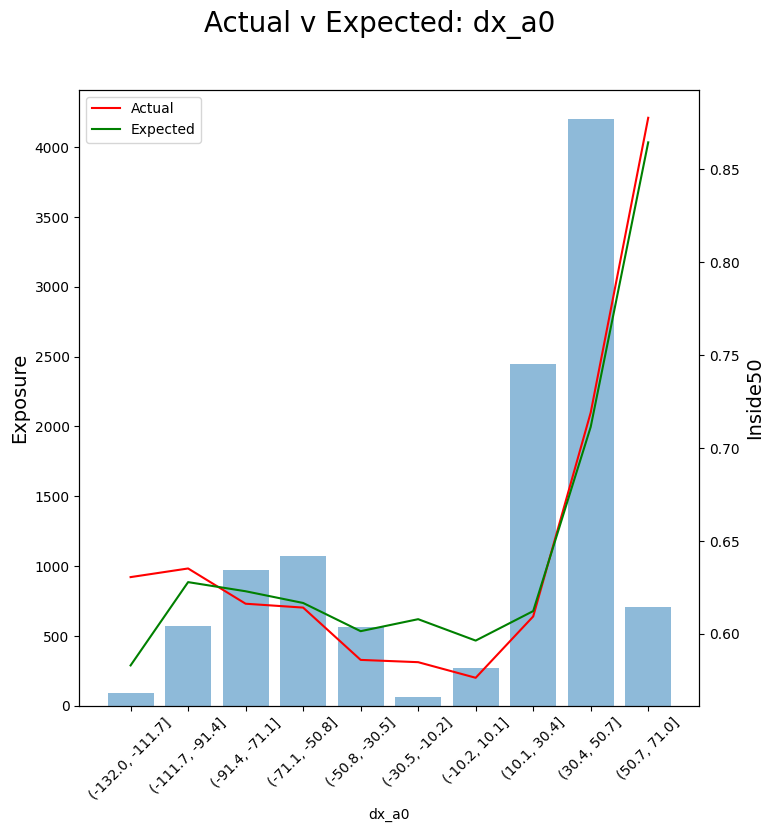

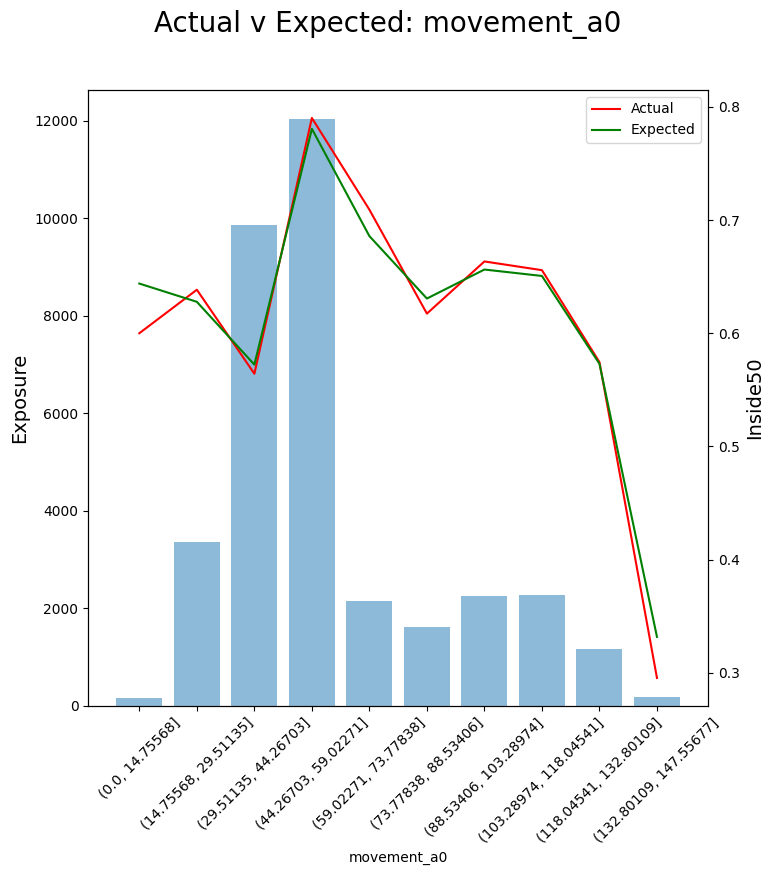

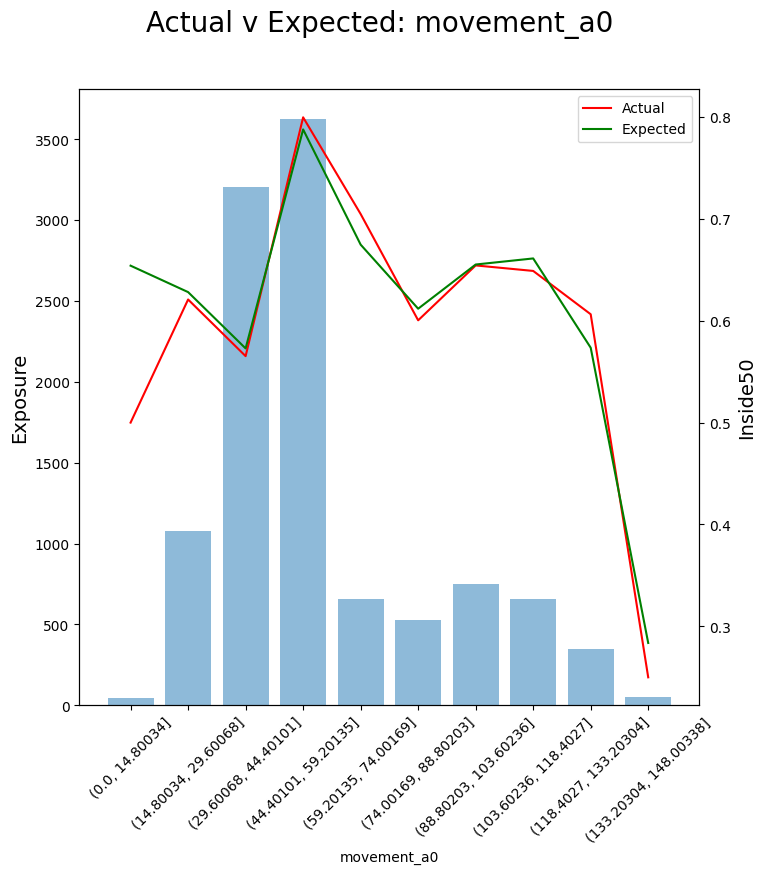

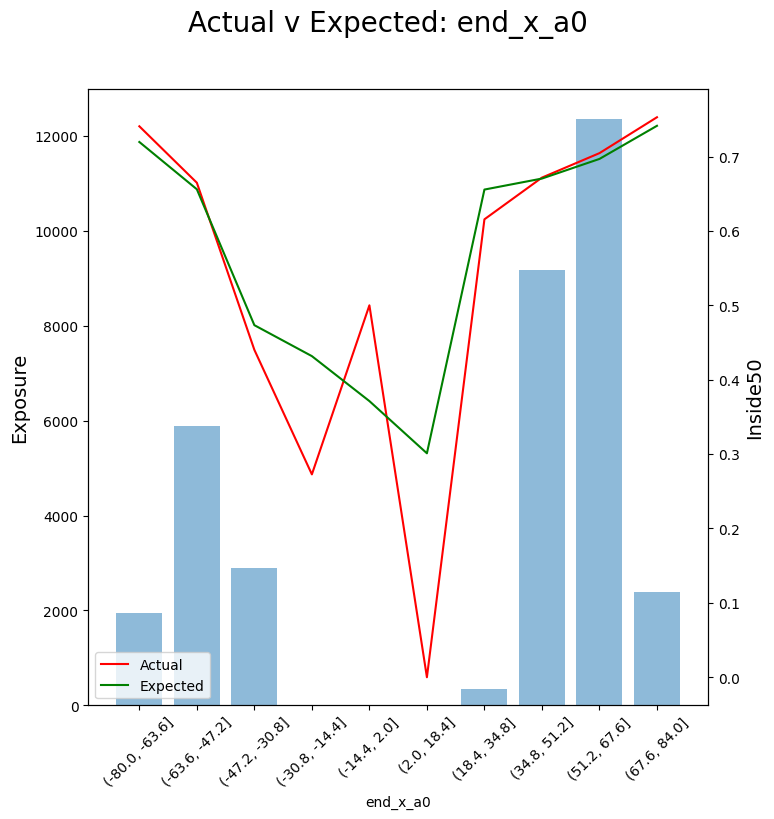

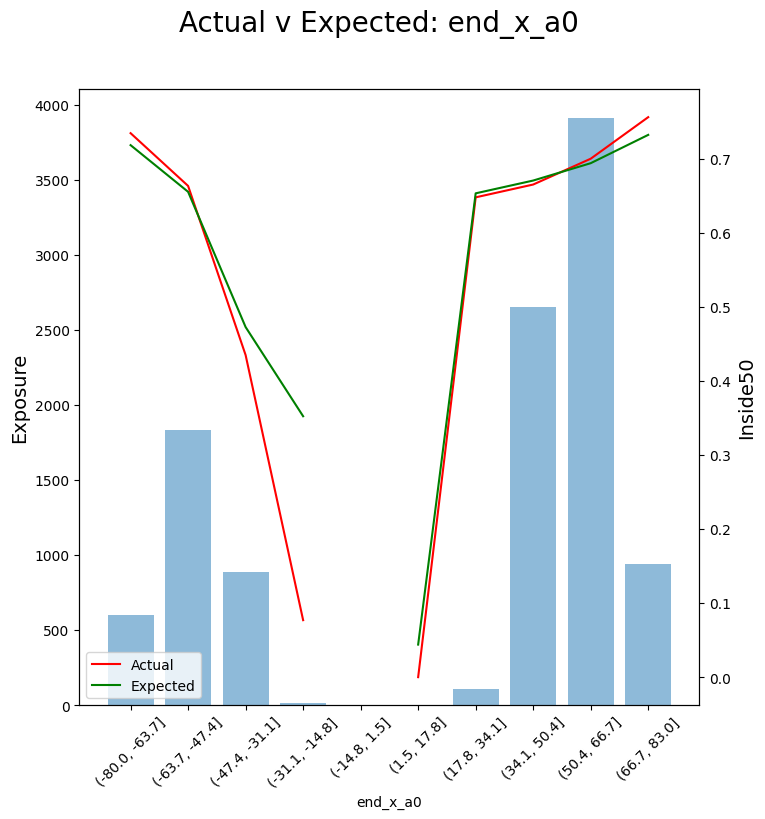

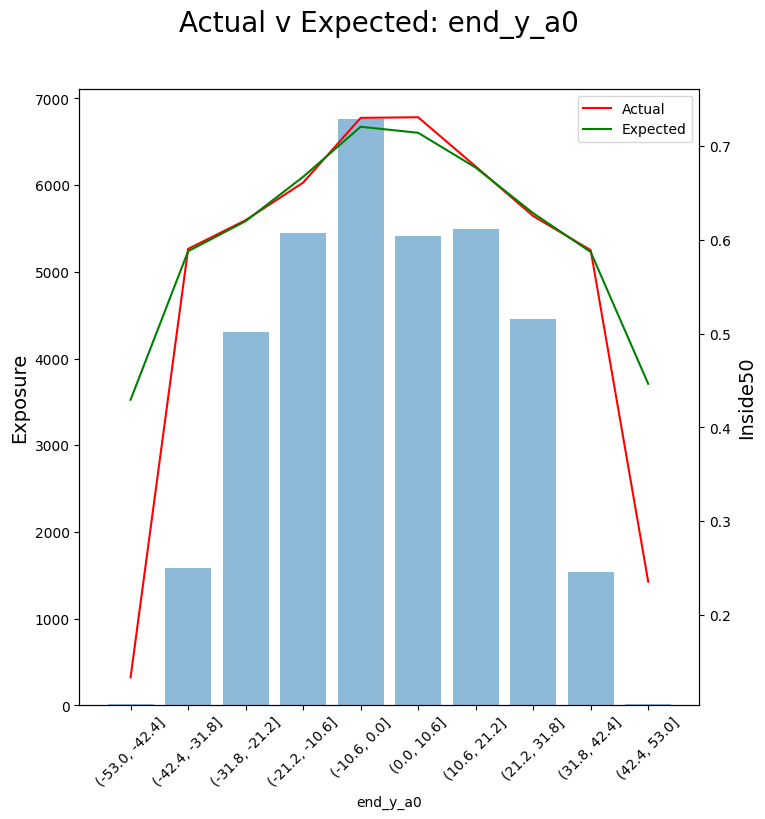

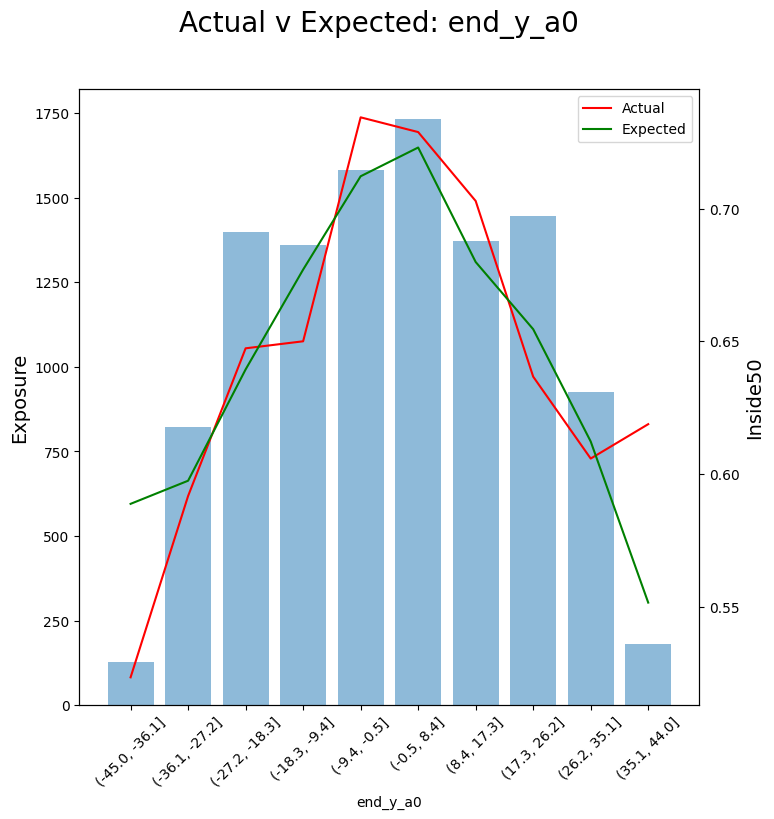

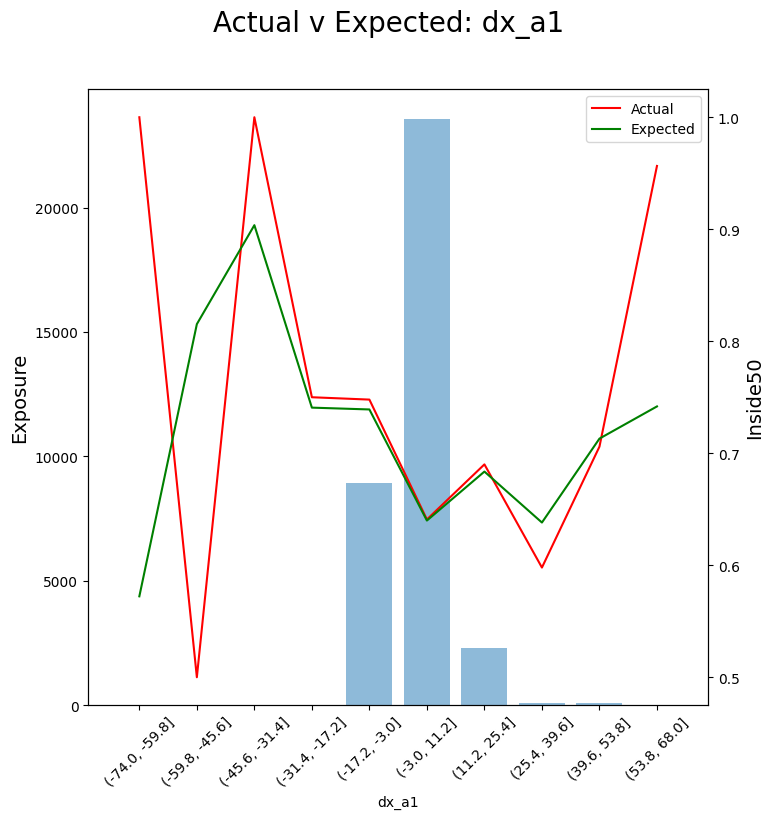

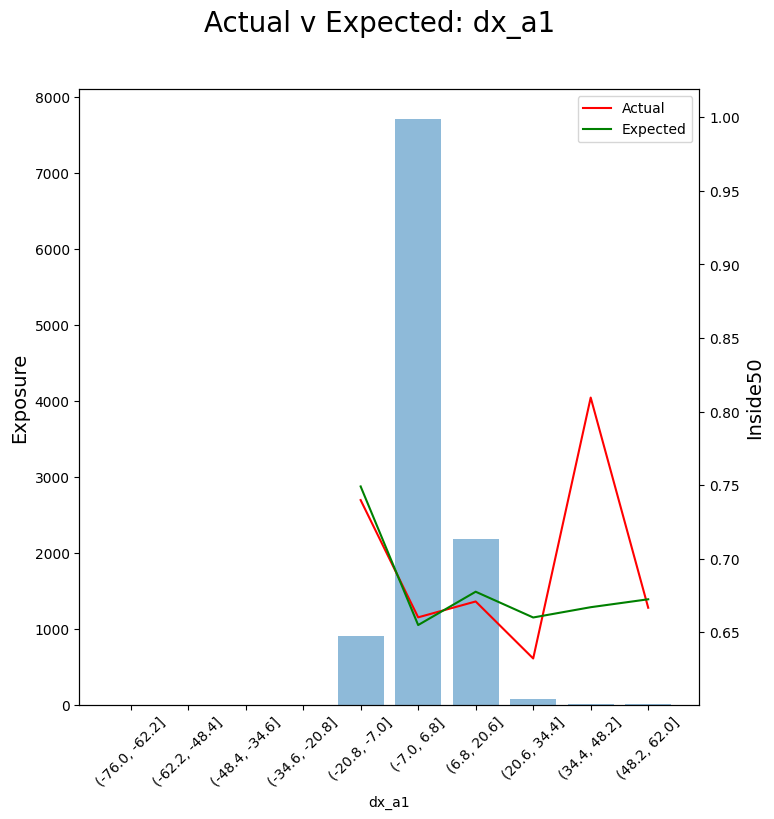

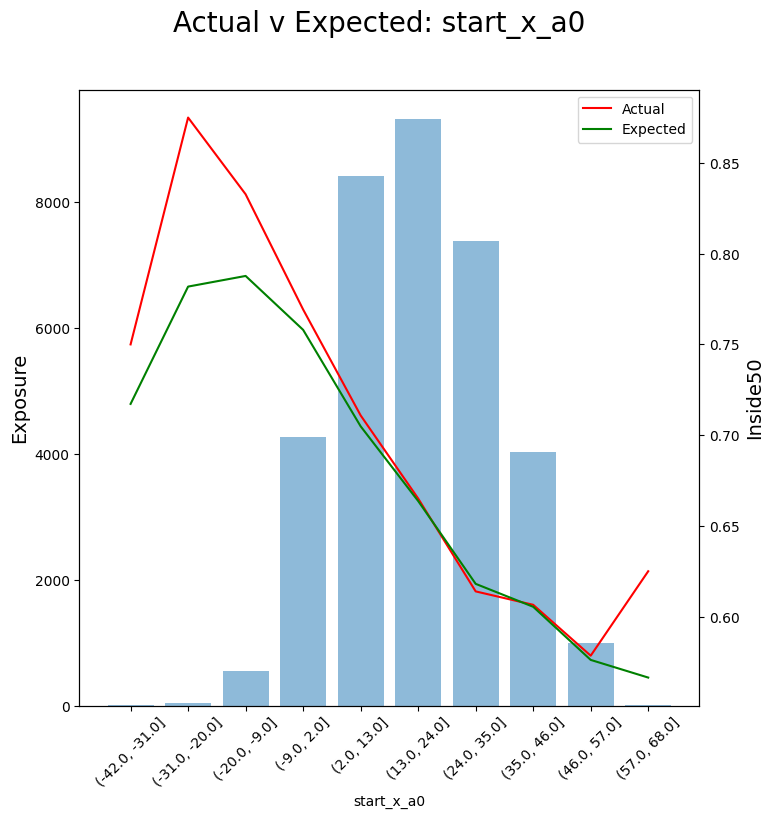

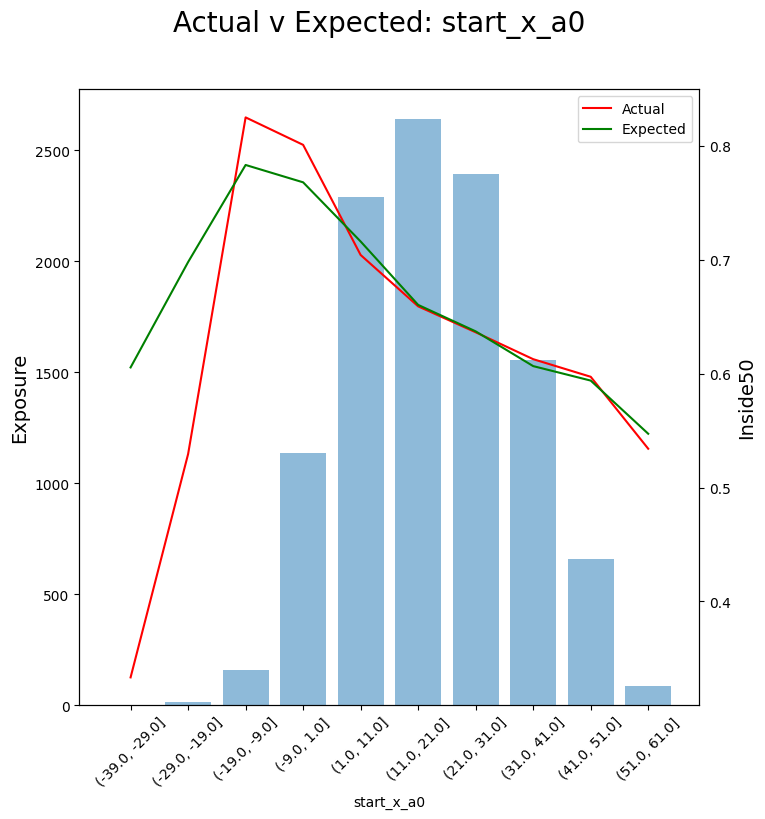

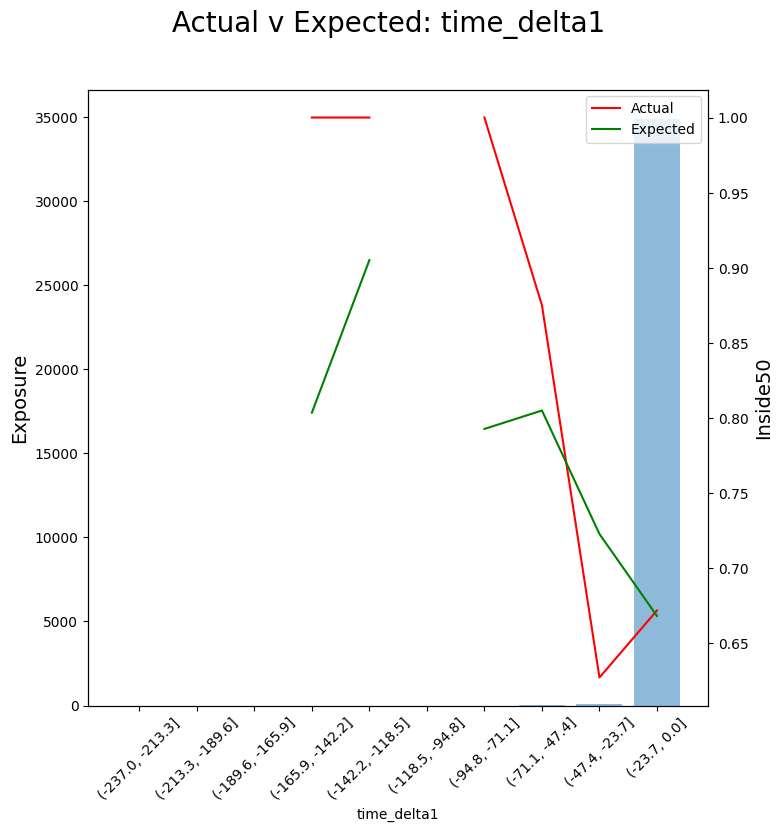

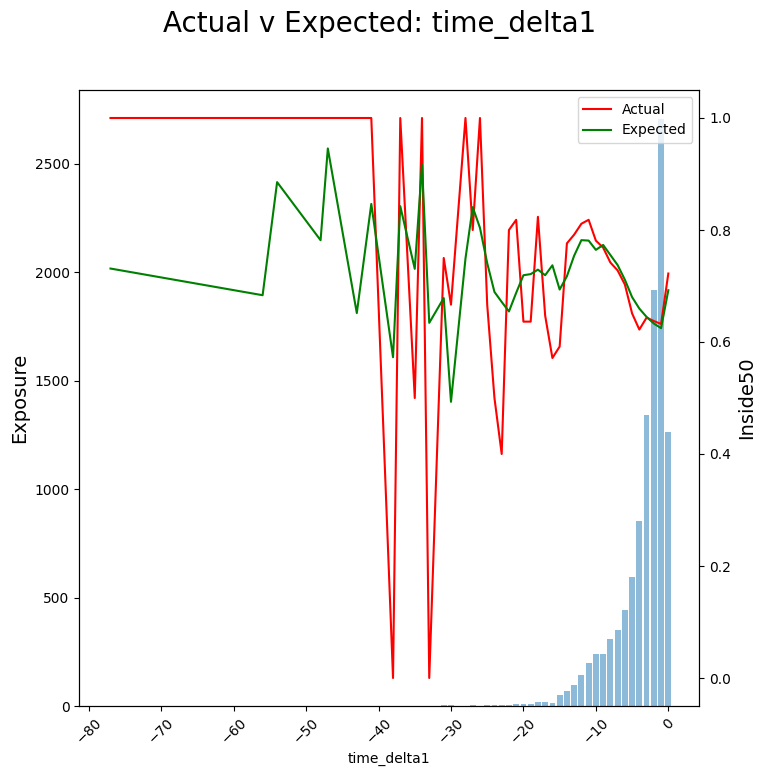

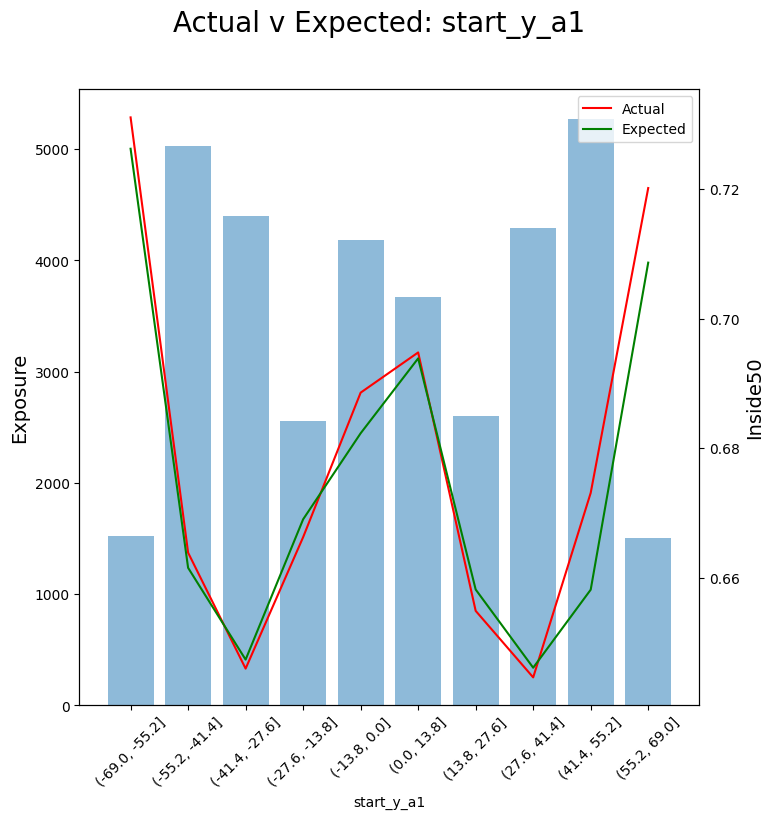

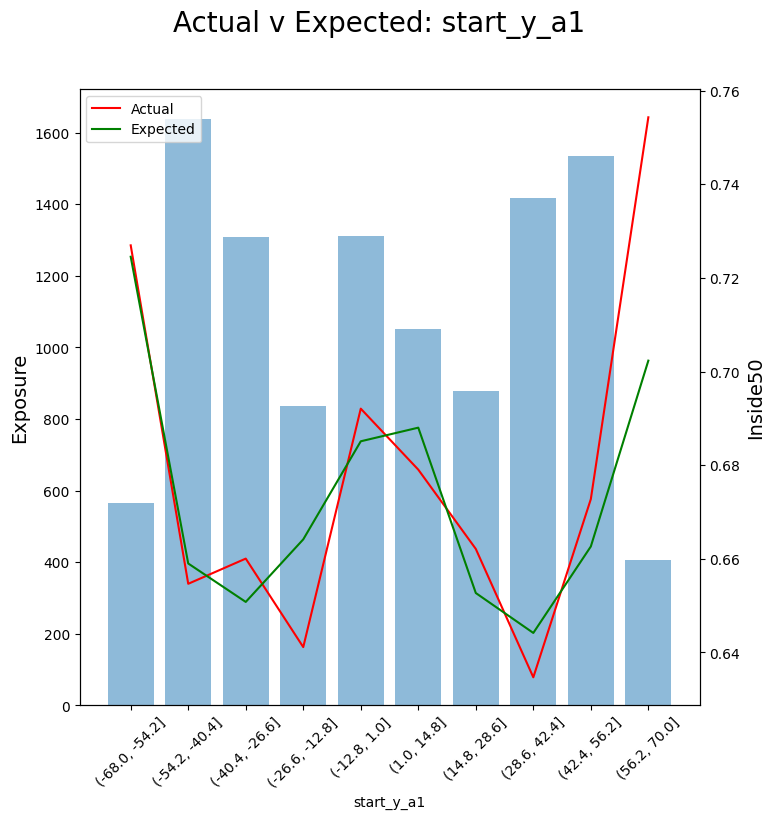

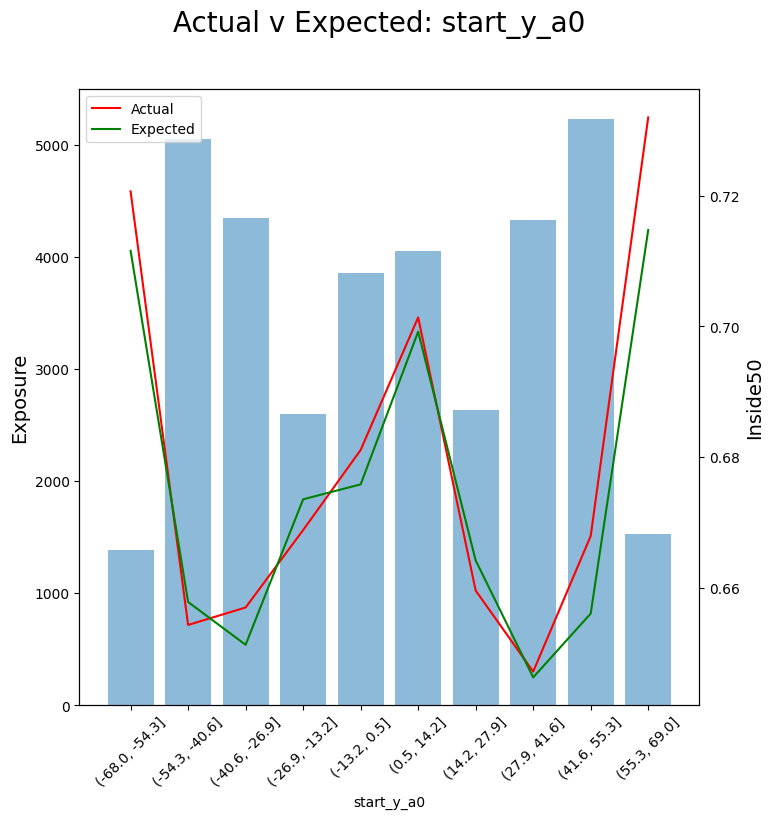

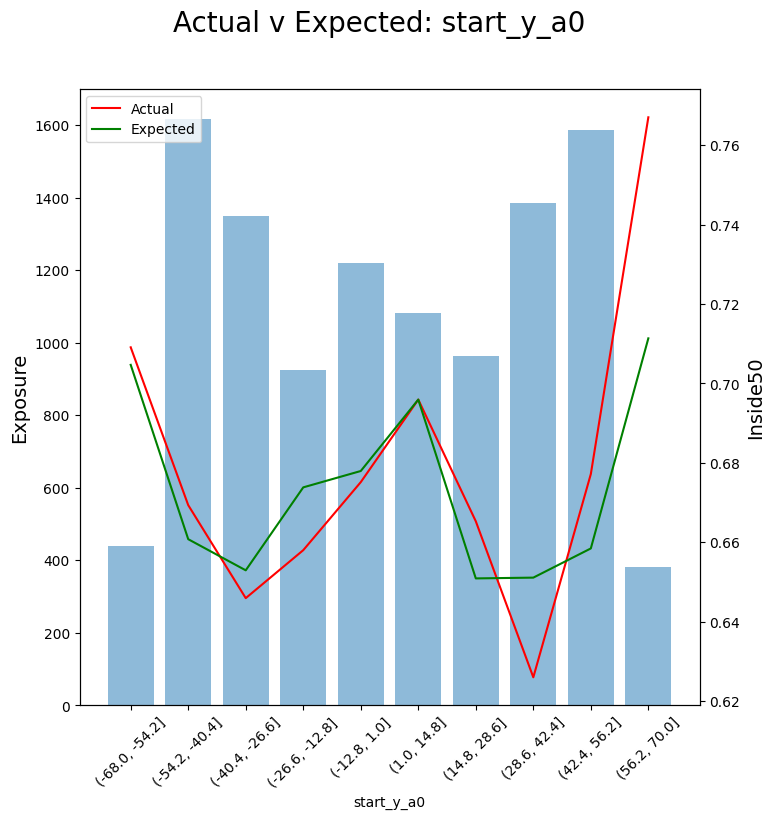

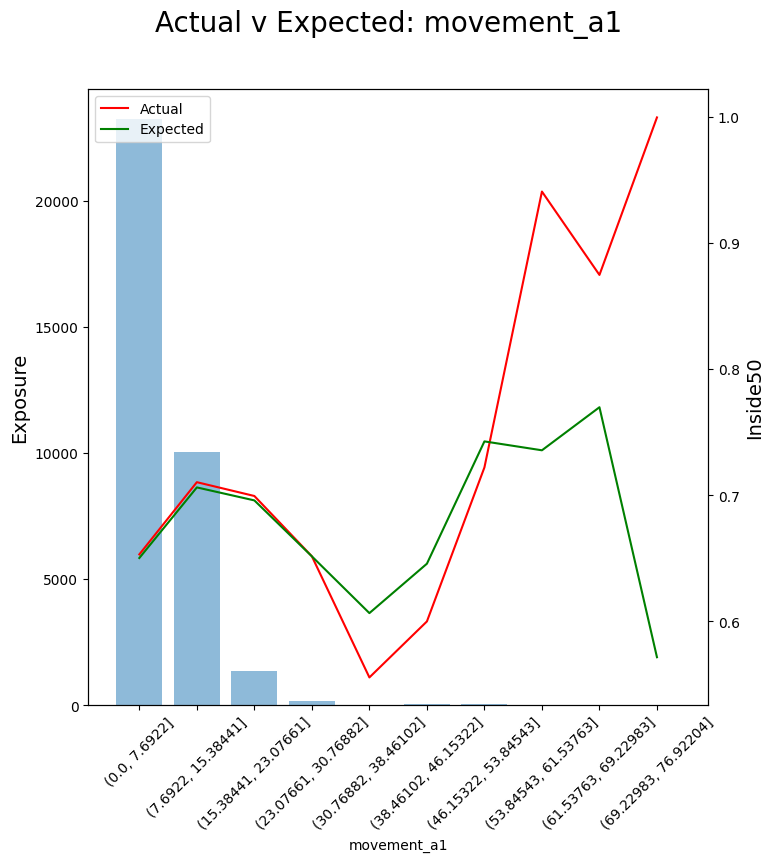

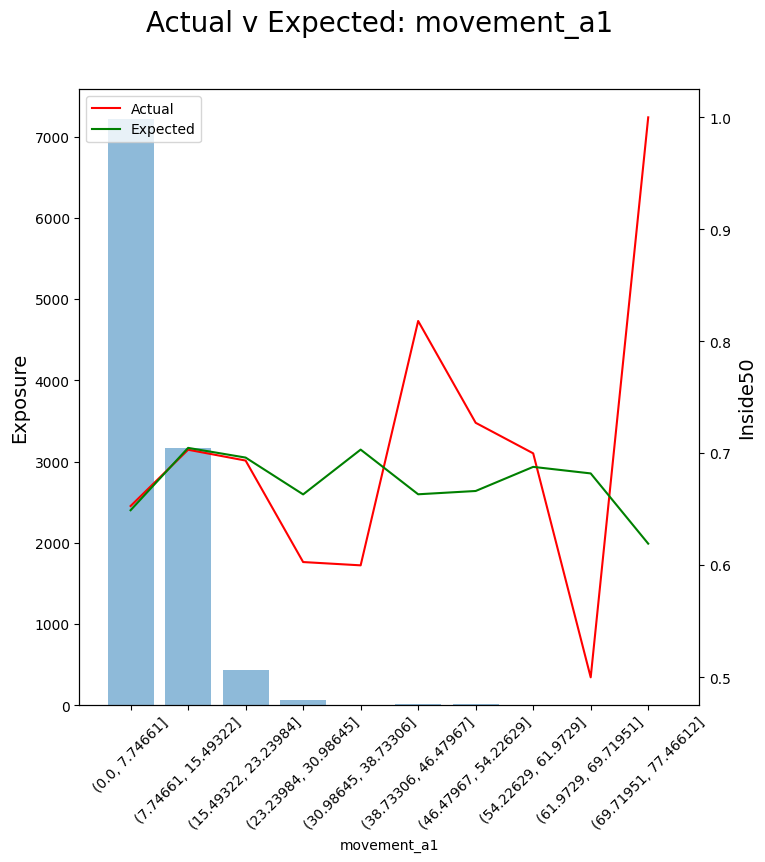

In [36]:
for col in top_10_features:
    train_xgb_evals.plot_feature_ave(col)
    test_xgb_evals.plot_feature_ave(col)

Model Metrics (for probabilities, mainly want calibration curve, logloss and brier score loss)

In [37]:
train_xgb_evals.get_log_loss(), test_xgb_evals.get_log_loss()

Expected Log-Loss: 	0.5138
Expected Log-Loss: 	0.5393


(0.5138034674123717, 0.5393362821062925)

In [38]:
train_xgb_evals.get_brier_score_loss(), test_xgb_evals.get_brier_score_loss()

Expected Brier Score: 	0.1709
Expected Brier Score: 	0.1814


(0.17085198376101954, 0.1813635211271896)

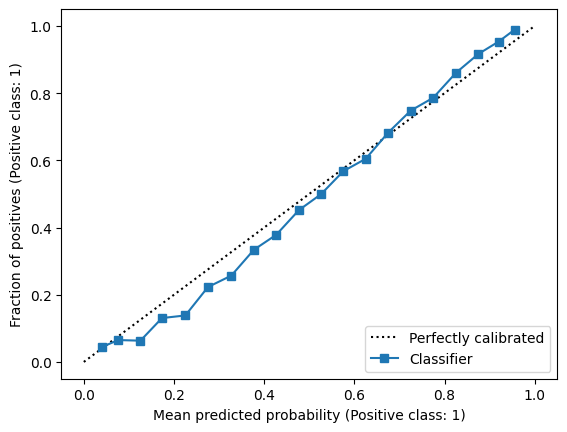

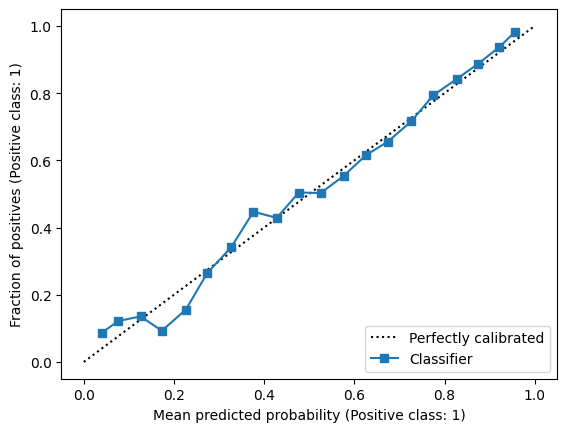

In [39]:
train_xgb_evals.display_calibration_curve(nbins=20)
test_xgb_evals.display_calibration_curve(nbins=20)